In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers,models,Sequential
import tensorflow_hub as hub
%matplotlib inline

In [3]:
IMAGE_SIZE=256
BATCH_SIZE=32

In [4]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage',
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_name=dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

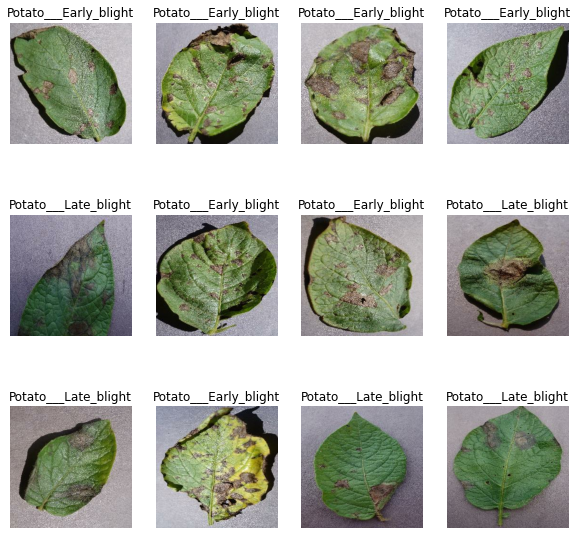

In [6]:
plt.figure(figsize=(10,10))
for image, labels in dataset.take(1):
    for i in range(12) :
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(class_name[labels[i]])

In [7]:
len(dataset)
int(0.8*len(dataset))

54

In [7]:
def train_test_val_split(ds,train_size=0.8,test_size=0.1,val_size=0.1,shuffle=True,shuffle_size=10000):
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    ds_size=len(ds)
    
    train_size=int(train_size*ds_size)
    val_size=int(val_size*ds_size)
    
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [8]:
train_ds,val_ds,test_ds=train_test_val_split(dataset)

In [9]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


In [10]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
resize_and_rescale=Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [13]:
data_aug=Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [18]:
model=Sequential([
    resize_and_rescale,
    data_aug,
    
    layers.Conv2D(32,(3,3),activation='relu',input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(32,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dense(3,activation='softmax')

])

model.build(input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (32, 60, 60, 64)         

In [21]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [22]:
history=model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    verbose=1,
    batch_size=BATCH_SIZE
)

Epoch 1/10
54/54 [==============================] - 371s 5s/step - loss: 0.9167 - accuracy: 0.4844 - val_loss: 0.7988 - val_accuracy: 0.4375
Epoch 2/10
54/54 [==============================] - 223s 4s/step - loss: 0.5124 - accuracy: 0.7928 - val_loss: 0.4022 - val_accuracy: 0.8333
Epoch 3/10
54/54 [==============================] - 201s 4s/step - loss: 0.3406 - accuracy: 0.8576 - val_loss: 0.3056 - val_accuracy: 0.8542
Epoch 4/10
54/54 [==============================] - 203s 4s/step - loss: 0.2806 - accuracy: 0.8843 - val_loss: 0.2415 - val_accuracy: 0.9219
Epoch 5/10
54/54 [==============================] - 203s 4s/step - loss: 0.2365 - accuracy: 0.9034 - val_loss: 0.2129 - val_accuracy: 0.8958
Epoch 6/10
54/54 [==============================] - 202s 4s/step - loss: 0.1733 - accuracy: 0.9363 - val_loss: 0.1309 - val_accuracy: 0.9427
Epoch 7/10
54/54 [==============================] - 202s 4s/step - loss: 0.1667 - accuracy: 0.9375 - val_loss: 0.1784 - val_accuracy: 0.9271
Epoch 8/10
54

In [23]:
model.evaluate(test_ds)

8/8 [==============================] - 76s 1s/step - loss: 0.1788 - accuracy: 0.9336


[0.17877119779586792, 0.93359375]

In [24]:
history

In [25]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [27]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
history.history['accuracy']

[0.484375,
 0.7928240895271301,
 0.8576388955116272,
 0.8842592835426331,
 0.9033564925193787,
 0.9363425970077515,
 0.9375,
 0.9328703880310059,
 0.9589120149612427,
 0.9409722089767456]

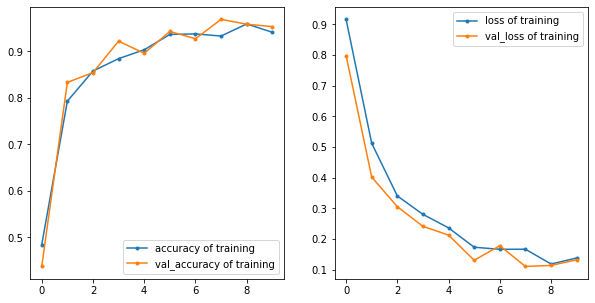

In [43]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(10),history.history['accuracy'],label='accuracy of training',marker='.')
plt.plot(range(10),history.history['val_accuracy'],label='val_accuracy of training',marker='.')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(10),history.history['loss'],label='loss of training',marker='.')
plt.plot(range(10),history.history['val_loss'],label='val_loss of training',marker='.')
plt.legend()

# Transfer learning

In [11]:
transfer_resize_resclae=Sequential([
    layers.experimental.preprocessing.Resizing(224,224),
    layers.experimental.preprocessing.Rescaling(1./255.0)
])

In [12]:
classifier=Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",input_shape=(224,224,3),trainable=False)
])

In [15]:
transfer_model=Sequential([
    transfer_resize_resclae,
    classifier,
    layers.Dense(3,activation='softmax')
])
transfer_model.build(input_shape=(32,224,224,3))
transfer_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 224, 224, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (32, 3)                   3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [16]:
transfer_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
transfer_history=transfer_model.fit(
    train_ds,
    epochs=3,
    validation_data=val_ds,
    batch_size=BATCH_SIZE,
    verbose=1
)

Epoch 1/3
54/54 [==============================] - ETA: 0s - loss: 0.3872 - accuracy: 0.86 - 237s 3s/step - loss: 0.3872 - accuracy: 0.8669 - val_loss: 0.2007 - val_accuracy: 0.9323
Epoch 2/3
54/54 [==============================] - 96s 2s/step - loss: 0.1339 - accuracy: 0.9612 - val_loss: 0.1393 - val_accuracy: 0.9583
Epoch 3/3
54/54 [==============================] - 85s 2s/step - loss: 0.0940 - accuracy: 0.9740 - val_loss: 0.1066 - val_accuracy: 0.9688


In [18]:
transfer_model.evaluate(test_ds)

8/8 [==============================] - 51s 1s/step - loss: 0.0547 - accuracy: 1.0000


[0.05472499877214432, 1.0]

In [19]:
transfer_history

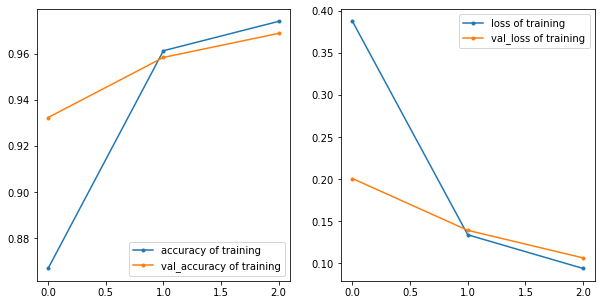

In [21]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(3),transfer_history.history['accuracy'],label='accuracy of training',marker='.')
plt.plot(range(3),transfer_history.history['val_accuracy'],label='val_accuracy of training',marker='.')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(3),transfer_history.history['loss'],label='loss of training',marker='.')
plt.plot(range(3),transfer_history.history['val_loss'],label='val_loss of training',marker='.')
plt.legend()

In [25]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = transfer_model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

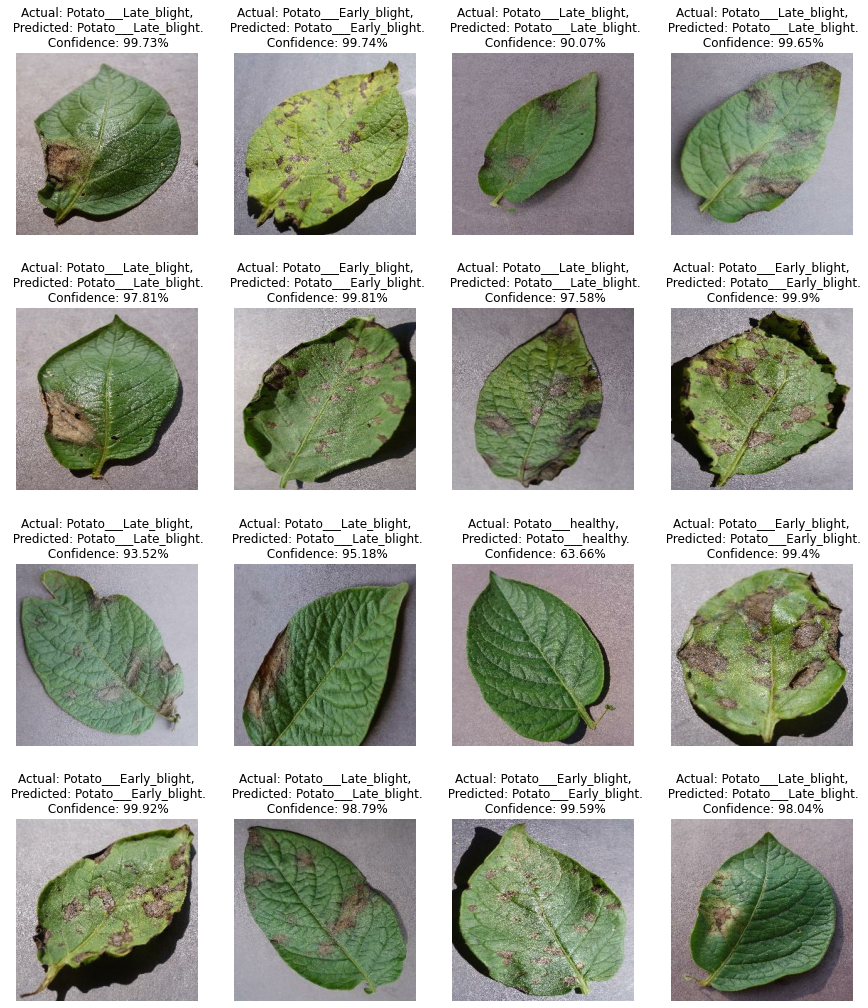

In [30]:
plt.figure(figsize=(15, 18))
for images, labels in test_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(transfer_model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [33]:
import os
model_version=max([int(i) for i in os.listdir('../saved_models')]+[0])+1
transfer_model.save(f'../saved_models/{model_version}')

INFO:tensorflow:Assets written to: ../saved_models/3\assets


INFO:tensorflow:Assets written to: ../saved_models/3\assets


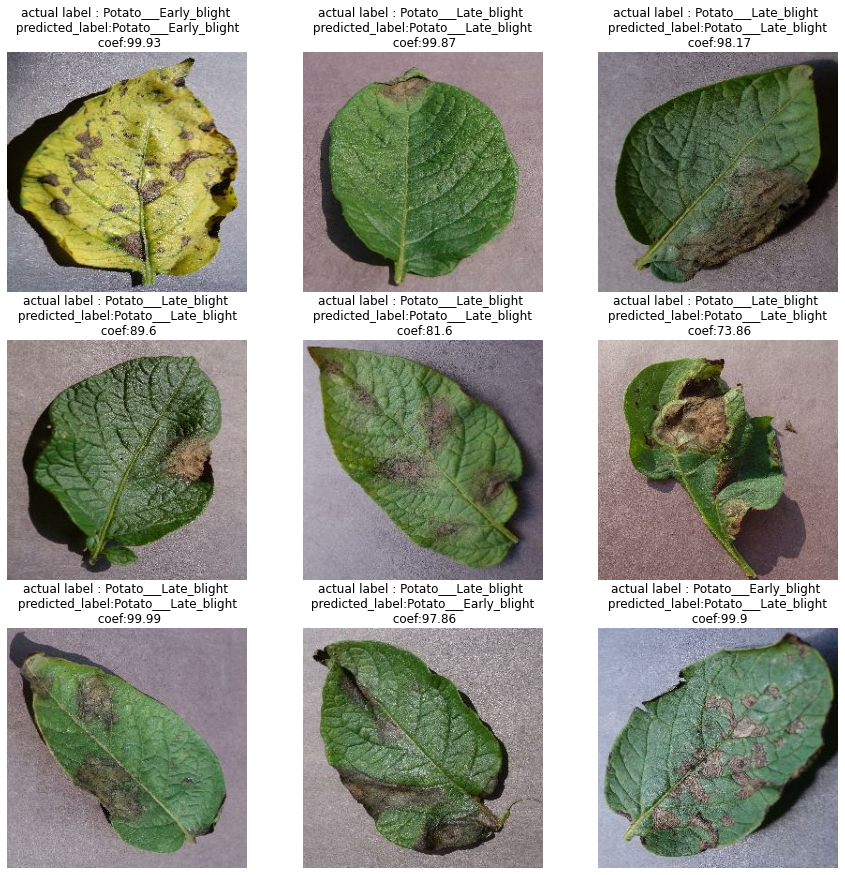

In [91]:
plt.figure(figsize=(15,15))
predicted=model.predict(test_ds.take(1))
predicted1=[np.argmax(j) for j in predicted]
coef=[round(np.max(k)*100,2) for k in predicted]
for images,labels in test_ds.take(1):
    for i in range(9):

        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(f"actual label : {class_name[labels[i]]} \n predicted_label:{class_name[predicted1[i]]} \n coef:{coef[i]}")

In [86]:
for i in model.predict(test_ds.take(1)):
    print(np.max(i)*100)


99.9968409538269
88.13048005104065
96.95884585380554
99.0701675415039
99.33497309684753
95.42880654335022
98.50705862045288
99.996817111969
89.24599885940552
99.99853372573853
92.75564551353455
95.53143978118896
98.03667664527893
99.04739260673523
99.8969554901123
95.3038215637207
99.97418522834778
89.48816657066345
99.98911619186401
99.9750554561615
52.99917459487915
82.5695812702179
99.986732006073
99.98112320899963
99.82786178588867
99.98227953910828
96.07751965522766
99.99024868011475
90.25204181671143
96.63024544715881
99.80835914611816
99.95391368865967


In [92]:
import os
model_version=max([int(i) for i in os.listdir('../models')]+[0])+1
model.save(f'../models/{model_version}')

INFO:tensorflow:Assets written to: ../models/2\assets
